# Import Modules 

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler, QuantileTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.cross_validation import KFold, StratifiedKFold
from IPython.display import display
from sklearn import metrics

from sklearn.preprocessing import Imputer
import missingno as msno

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
#input data
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

# Explore Data

In [4]:
data_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [5]:
data_train.shape,data_test.shape

((1460, 81), (1459, 80))

There are a lot of '0' in the data. For example, the poolarea and 3ssnporch equal to 0 may means there is no porch in the house.

# Feature Engineering

In [5]:
# Convert ordinal feature to numeric feature
has_rank = [col for col in data_train.columns if 'TA' in list(data_train[col])]
dic_num = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

for col in has_rank:
    data_train[col] = data_train[col].map(dic_num)

In [6]:
#Categorical vs Numerical

data_train['MSSubClass'] = data_train['MSSubClass'].astype('category')

#Categoric to Numeric
to_num_col = ['OverallQual','OverallCond', 'YearBuilt', 'YearRemodAdd' ]

for col in to_num_col:
    data_train[col] = data_train[col].astype('int32')

In [7]:
#Removing features with variance lower than 0.8
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))

num_df = data_train.select_dtypes('int')
sel.fit(num_df)
num_df = num_df[num_df.columns[sel.get_support(indices=False)]]

for col in data_train.select_dtypes('int').columns:
    if col not in num_df:
        print(col)

data_train[num_df.columns] = num_df
data_train.drop(['ExterCond','BsmtHalfBath','KitchenAbvGr'], axis =1 , inplace = True)

ExterCond
BsmtHalfBath
KitchenAbvGr


# Data Cleaning

In [50]:
#Inspecting the missing value
na_count = data_train.isnull().sum().sort_values( ascending=False )
na_percent = (data_train.isnull().sum()/data_train.isnull().count()).sort_values(ascending = False)
missing_value = pd.concat([na_count, na_percent], axis=1, keys = ['Count','Percent'])
missing_value[missing_value['Percent']>0]

,Count,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


For variables has higher than 70% missing value, they will be directly dropped. For other missing values, I will check if they are important variable using correlation.

In [51]:
#Variable with missing value < 50%
data_train.drop((missing_value[missing_value['Percent'] > 0.5]).index, axis = 1, inplace = True)

In [53]:
#Check correlation of numerical variable
data_train.corr()['SalePrice'].loc[missing_value[missing_value['Percent']>0].index]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


PoolQC               NaN
MiscFeature          NaN
Alley                NaN
Fence                NaN
FireplaceQu     0.295794
LotFrontage     0.351799
GarageType           NaN
GarageCond      0.125013
GarageYrBlt     0.486362
GarageFinish         NaN
GarageQual      0.156693
BsmtExposure         NaN
BsmtFinType2         NaN
BsmtCond        0.160658
BsmtQual        0.644019
BsmtFinType1         NaN
MasVnrArea      0.477493
MasVnrType           NaN
Electrical           NaN
Name: SalePrice, dtype: float64

FirePlace and LotFrontage both have relatively high missing value percentge.

For Fireplace, because it is related to another vairable FirePlaceQu which do not has any missing value. We would assume the missing value do not have any actual meaning, so we replace it with mode.
For LotFrontage, it only has 0.35 correlation with saleprice, so we drop it.
For all the other variables with missing value, since the missing value percentage is quiet low, we'll use mode for categorical variable and mean for numerical variable for imputation. 

In [54]:
data_train.drop(['LotFrontage'], axis = 1, inplace = True)

In [55]:
data_train.head(10)
#So far so good!

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
5,6,50,RL,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,320,0,0,700,10,2009,WD,Normal,143000
6,7,20,RL,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,307000
7,8,60,RL,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,228,0,0,0,350,11,2009,WD,Normal,200000
8,9,50,RM,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,10,190,RL,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,1,2008,WD,Normal,118000


In [56]:
#Now, let's replace those missing values!

categoric_col=['FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual','MasVnrType', 'Electrical'] 
numeric_col=['GarageYrBlt','MasVnrArea']

for col in numeric_col:
    data_train[col].fillna(data_train[col].mean(),inplace=True)


for col in categoric_col:
    data_train[col].fillna(data_train[col].mode()[0],inplace=True)

data_train.isnull().sum().sort_values(ascending = False)[0]

#Yeah, all the missing value are replaced!

0

# Feature Selection

There are many categorical variables in our data, so I choose random forest for feature selection. Since I'll use XGboost to predict the result, there is no need to perform feature scalling.

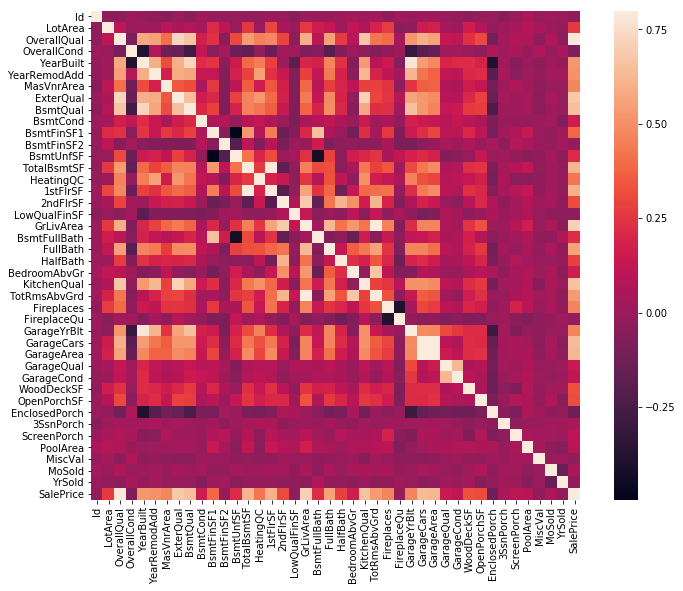

In [61]:
#Heat map of top 15 correlated metrics
corrmat = data_train.corr()
col11 = corrmat['SalePrice'].sort_values(ascending=False).head(11).index
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [124]:
y = data_train.iloc[:,-1]
X = pd.get_dummies(data_train.iloc[:,1:-1])
X.shape
(1460, 253)
feature = X.columns

In [126]:
#Tree-based feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [128]:
sfm = SelectFromModel(clf)
sfm.fit(X, y)

select_feature = []
for feature_list_index in sfm.get_support(indices=True):
    select_feature.append((feature[feature_list_index]))

# Data Modelling - XGBoost

First, we run the original model to see the performance and then use crossvalidation to tune the parameter.

In [138]:
#XGboosting Modelling 

import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

#Split train and test data
X_1 = X[select_feature]

X_1.shape
(1460, 70)
X_train,X_test,y_train,y_test=train_test_split(X_1,y, test_size=0.3, random_state=31)
my_model.fit(X_train, y_train, verbose=False)

my_model = XGBRegressor()
y_predict1 = my_model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print('R2 score: %.2f' % r2_score(y_test, y_predict1))
rmse = np.sqrt(mean_squared_error(y_test, y_predict1))
print('RMSE: %.2f' % rmse)

R2 score: 0.86
30414.181877739982


(1460, 70)

In [136]:
#Prepare the test_data

#Ordinal variable to Numeric variable
has_rank = [col for col in data_test.columns if 'TA' in list(data_test[col])]
dic_num = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

for col in has_rank:
    data_test[col] = data_test[col].map(dic_num)

#Categoric to Numeric    
data_test['YearBuilt'] = data_test['YearBuilt'].astype('int32')
data_test['YearRemodAdd'] = data_test['YearRemodAdd'].astype('int32')
data_test['OverallQual'] = data_test['OverallQual'].astype('int32')

data_test['MSSubClass_20'] = 0
data_test1 = pd.get_dummies(data_test)[select_feature]

In [137]:
# Fill in the missing value
miss_col = ['GarageCars','TotalBsmtSF','BsmtQual','KitchenQual']

for col in miss_col:
    data_test1[col].fillna(data_test1[col].mean(),inplace=True)


data_test1.isnull().sum().sort_values(ascending = False)[0]

#scaled_test = scaler.fit_transform(data_test1)
#scaled_test = pd.DataFrame(scaled_test, columns = data_test1.columns)

data_test1.shape

(1459, 70)

In [141]:
#XGboost Raw Model Prediction Result
xgboost_predict = pd.DataFrame(my_model.predict(data_test1),columns = ['SalePrice'])
xgboost_predict.head()

,SalePrice
0,122225.640625
1,166036.984375
2,174602.734375
3,183902.812500
4,200538.281250


In [142]:
df_output = pd.concat([data_test[['Id']],xgboost_predict],axis=1)
df_output.head(10)
df_output.to_csv('result_xg.csv', encoding='utf-8', index=False)

,Id,SalePrice
0,1461,122225.640625
1,1462,166036.984375
2,1463,174602.734375
3,1464,183902.812500
4,1465,200538.281250
5,1466,171676.031250
6,1467,159667.203125
7,1468,164282.312500
8,1469,185777.671875
9,1470,122751.476562


# Model Tunning

In [156]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV   

In [161]:
def modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y, eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    
        
    #Print model report:
    print ("\nModel Report")
    print ("R2 score : %.4g" % metrics.r2_score(y.values, dtrain_predictions))
    print ("RMSE Score (Train): %f" % metrics.mean_squared_error(y, dtrain_predictions))

In [162]:
# Use previous function to get optimal estimator number
xg_reg1 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.1, min_child_weight=1,
                gamma=0,subsample=0.8, max_depth = 5, alpha = 50, n_estimators = 1000, nthread=4,
             scale_pos_weight=1, seed=27)
modelfit(xg_reg1, X_1, y)


Model Report
R2 score : 0.9929
RMSE Score (Train): 44733817.191487


In [166]:
#Get the optimal estimator number : 151
print (xg_reg1.get_params()['n_estimators'])

151


In [189]:
#Tune max_depth and min_child_weight
#Get the optimal 'max_depth': 5, 'min_child_weight': 3
param_test1 = {
 'max_depth':[3,4,5,6,7,8,9,10],
 'min_child_weight':[1,2,3,4,5,6]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.1, min_child_weight=1,
                gamma=0,subsample=0.8, max_depth = 5, alpha = 50, n_estimators = 151, nthread=4,
                scale_pos_weight=1, seed=27), 
                param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_1,y)
gsearch1.best_params_, gsearch1.best_score_

([mean: -769481059.67992, std: 215149831.30539, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -791087995.27718, std: 169173254.56853, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: -699527860.70273, std: 201775278.40765, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -747862175.72522, std: 195368978.76596, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: -820546413.29892, std: 271085520.41587, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -825797344.84068, std: 236218241.18764, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: -774500256.92069, std: 221754790.45691, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -753376733.29099, std: 145228499.55554, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: -745770596.95013, std: 211697538.08965, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -768048201.57087, std: 221099200.44823, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -792307608.48790, std:

In [188]:
#Tune gamma
#Get the optimal 'gamme': 0
param_test3 = {
 'gamma':[0,0.1,0.2,0.3,0.4,0.5]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.1, min_child_weight=3,
                gamma=0,subsample=0.8, max_depth = 5, alpha = 50, n_estimators = 151, nthread=4,
                scale_pos_weight=1, seed=27), 
                param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_1,y)
gsearch3.best_params_, gsearch3.best_score_

([mean: -689762654.39802, std: 179408838.10521, params: {'gamma': 0},
  mean: -689762654.39802, std: 179408838.10521, params: {'gamma': 0.1},
  mean: -689762654.39802, std: 179408838.10521, params: {'gamma': 0.2},
  mean: -689762654.39802, std: 179408838.10521, params: {'gamma': 0.3},
  mean: -689762654.39802, std: 179408838.10521, params: {'gamma': 0.4},
  mean: -689762654.39802, std: 179408838.10521, params: {'gamma': 0.5}],
 {'gamma': 0},
 -689762654.3980207)

In [191]:
#Tune subsample and colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.1, min_child_weight=3,
                gamma=0,subsample=0.8, max_depth = 5, alpha = 50, n_estimators = 151, nthread=4,
                scale_pos_weight=1, seed=27), 
         param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_1,y)
gsearch4.best_params_, gsearch4.best_score_

([mean: -773806321.68905, std: 243410292.17032, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -743202778.70608, std: 226350559.58639, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -746669096.01689, std: 207345165.65668, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -722880460.16646, std: 203419864.94710, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -783520824.93502, std: 236570991.85695, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -753400563.75202, std: 216829812.07690, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -733069426.56778, std: 213198787.46587, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -713993889.08366, std: 210925913.21315, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -777926455.94218, std: 253758913.66497, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -710826868.00058, std: 182661305.71647, params: {'colsample_bytree': 0.8, 'subsampl

In [192]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.1, min_child_weight=3,
                gamma=0,subsample=0.8, max_depth = 5, alpha = 50, n_estimators = 151, nthread=4,
                scale_pos_weight=1, seed=27), 
         param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_1,y)
gsearch5.best_params_, gsearch4.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(alpha=50, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=3, missing=None, n_estimators=151,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.1, min_child_weight=3,
                gamma=0,subsample=0.8, max_depth = 5, alpha = 50, n_estimators = 151, nthread=4,
                scale_pos_weight=1, seed=27), 
         param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_1, y)
gsearch6.best_params_, gsearch6.best_score_

In [204]:
param_test7 = {
 'reg_alpha':[90,100,110]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.1, min_child_weight=3,
                gamma=0,subsample=0.8, max_depth = 5, alpha = 50, n_estimators = 151, nthread=4,
                scale_pos_weight=1, seed=27), 
         param_grid = param_test7, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_1, y)
gsearch7.best_params_, gsearch7.best_score_

([mean: -687196585.14360, std: 183377665.02458, params: {'reg_alpha': 90},
  mean: -687042182.67909, std: 184124733.08661, params: {'reg_alpha': 100},
  mean: -684015210.82962, std: 183412421.76140, params: {'reg_alpha': 110}],
 {'reg_alpha': 110},
 -684015210.8296217)

In [209]:
#Now, increase the learning rate and find the optimal estimator number
xgb4 = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=110,
 objective= 'reg:linear',
 scale_pos_weight=1,)
modelfit(xgb4, X_1 ,y)


Model Report
R2 score : 0.9952
RMSE Score (Train): 30179994.806622


In [210]:
#Optimal estimator number: 1919
print (xgb4.get_params()['n_estimators'])

1919


In [211]:
#Use the tunned parameter to fit the model and predict the result!
xg_reg_0 = xgb.XGBRegressor(objective ='reg:linear',learning_rate = 0.01, min_child_weight=3,
                gamma=0, max_depth = 5, n_estimators = 1919, colsample_bytree = 0.8, subsample=0.8,reg_alpha=110,
                scale_pos_weight=1)
xg_reg_0.fit(X_1,y)
xgboost_predict1 = pd.DataFrame(xg_reg_0.predict(data_test1),columns = ['SalePrice'])
df_output1 = pd.concat([data_test[['Id']],xgboost_predict1],axis=1)
df_output1.head(10)

,Id,SalePrice
0,1461,123683.703125
1,1462,157261.687500
2,1463,183373.687500
3,1464,192933.625000
4,1465,186228.562500
5,1466,174183.500000
6,1467,171558.328125
7,1468,171186.906250
8,1469,177585.500000
9,1470,119391.820312


In [212]:
#Export result to csv file
df_output1.to_csv('Xgb_result_new.csv',encoding='utf-8', index=False)